In [1]:
!git clone https://github.com/fanzeyi/pokemon.json.git --quiet > /dev/null 2>&1

In [2]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import os
import time
import glob
import json
import random
import base64
from io import BytesIO

import requests
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from PIL import Image as PILImage

import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, BatchNormalization, Conv2DTranspose, Reshape,
    LeakyReLU, Conv2D, Dropout, Flatten, Add, UpSampling2D
)

from IPython.display import HTML, clear_output, display as ipy_display

In [4]:
# 共通設定
IMG_SIZE = 128
EPOCHS = 3000
noise_dim = 100
num_examples_to_generate = 16

Total Pokémon: 809
['bulbasaur', 'ivysaur', 'venusaur', 'charmander', 'charmeleon', 'charizard', 'squirtle', 'wartortle', 'blastoise', 'caterpie']


✅ All Pokémon images downloaded and resized.


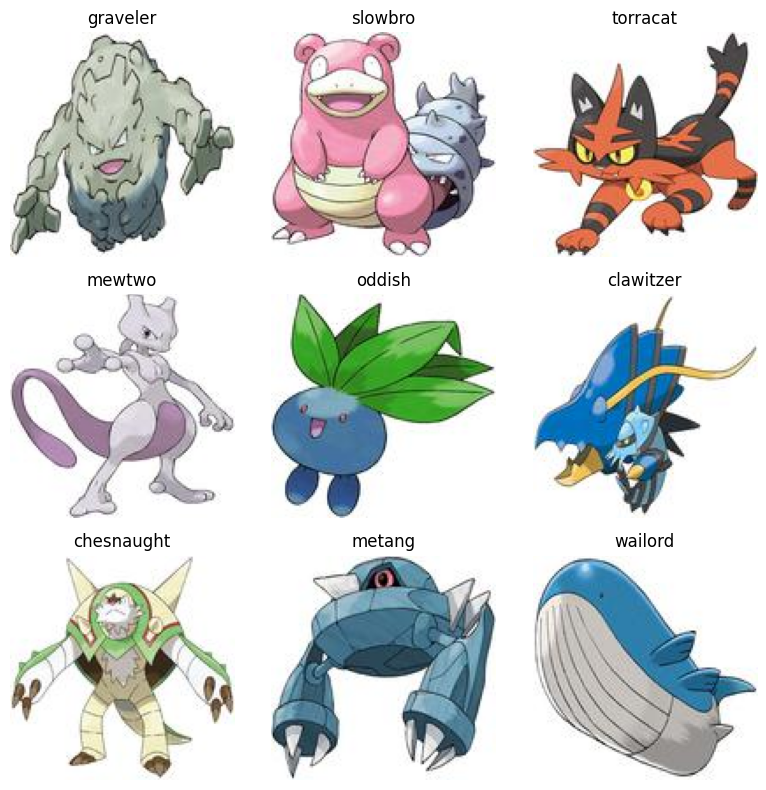

In [5]:
# 1. データ取得

# ポケモン名リスト作成
with open("pokemon.json/pokedex.json", encoding="utf-8") as f:
    pokedex = json.load(f)

pokemon_names = []
for entry in pokedex:
    name = entry["name"]["english"]
    name_url = name.lower().replace(" ", "-").replace(".", "").replace("'", "").replace(":", "").replace("é", "e")
    pokemon_names.append(name_url)

print(f"Total Pokémon: {len(pokemon_names)}")
print(pokemon_names[:10])

# 画像のダウンロードと保存
save_dir = "pokemon_images_full"
os.makedirs(save_dir, exist_ok=True)
base_url = "https://img.pokemondb.net/artwork/large/{}.jpg"

for name in tqdm(pokemon_names, desc="Downloading Pokémon images"):
    url = base_url.format(name)
    response = requests.get(url)
    if response.status_code == 200:
        try:
            img = Image.open(BytesIO(response.content)).convert("RGB")
            img = img.resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS)
            img.save(os.path.join(save_dir, f"{name}.jpg"))
        except:
            continue
    time.sleep(0.5)

print("✅ All Pokémon images downloaded and resized.")

# ダウンロード画像の確認
image_paths = glob.glob(os.path.join(save_dir, "*.jpg"))
sample_paths = random.sample(image_paths, min(9, len(image_paths)))

fig = plt.figure(figsize=(8, 8))
for i, path in enumerate(sample_paths):
    img = Image.open(path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(path).replace(".jpg", ""))
    plt.axis("off")

plt.tight_layout()
plt.show()
plt.close(fig)

In [6]:
# 2. データ前処理 (train_dataset作成)

# 画像前処理
def preprocess_image(path):
    img = Image.open(path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img)
    img = (img - 127.5) / 127.5
    return img

# 画像読み込み (進捗バーつきで可視化)
image_paths = glob.glob(os.path.join("pokemon_images_full", "*.jpg"))
all_images = []
for p in tqdm(image_paths, desc="Preprocessing Pokémon images"):
    all_images.append(preprocess_image(p))

all_images = np.array(all_images)
print(f"✅ Loaded {all_images.shape[0]} images, shape: {all_images.shape[1:]}")

# データセット作成
BUFFER_SIZE = all_images.shape[0]
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices(all_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Preprocessing Pokémon images: 100%|██████████| 802/802 [00:00<00:00, 1452.49it/s]


✅ Loaded 802 images, shape: (128, 128, 3)


In [7]:
# 3. Generator/Discriminator定義 (SA-DCGAN + EMA, 128x128)

# Generator用ResBlock
class ResBlockUp(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(ResBlockUp, self).__init__()
        self.upsample = UpSampling2D()
        self.conv1 = Conv2D(filters, (3,3), padding='same')
        self.bn1 = BatchNormalization()
        self.relu1 = LeakyReLU()
        self.conv2 = Conv2D(filters, (3,3), padding='same')
        self.bn2 = BatchNormalization()
        self.shortcut_conv = Conv2D(filters, (1,1), padding='same')
        self.shortcut_bn = BatchNormalization()
        self.relu_out = LeakyReLU()

    def call(self, x, training=True):
        shortcut = self.upsample(x)
        shortcut = self.shortcut_conv(shortcut)
        shortcut = self.shortcut_bn(shortcut, training=training)

        x = self.upsample(x)
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = Add()([x, shortcut])
        x = self.relu_out(x)
        return x

# Discriminator用ResBlock
class ResBlockDown(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(ResBlockDown, self).__init__()
        self.conv1 = Conv2D(filters, (3,3), strides=2, padding='same')
        self.relu1 = LeakyReLU()
        self.conv2 = Conv2D(filters, (3,3), padding='same')
        self.relu2 = LeakyReLU()
        self.shortcut_conv = Conv2D(filters, (1,1), strides=2, padding='same')

    def call(self, x, training=True):
        shortcut = self.shortcut_conv(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = Add()([x, shortcut])
        x = self.relu2(x)
        return x

# SpectralNormalization層
class SpectralNormalization(tf.keras.layers.Wrapper):
    def __init__(self, layer, **kwargs):
        super(SpectralNormalization, self).__init__(layer, **kwargs)

    def build(self, input_shape):
        self.layer.build(input_shape)
        self.w = self.layer.kernel
        self.u = self.add_weight(
            shape=(1, self.w.shape[-1]),
            initializer=tf.random_normal_initializer(),
            trainable=False,
            name='sn_u'
        )

    def call(self, inputs, training=None):
        w_shape = self.w.shape.as_list()
        w_reshaped = tf.reshape(self.w, [-1, w_shape[-1]])

        u_hat = self.u
        v_hat = tf.linalg.l2_normalize(tf.matmul(u_hat, tf.transpose(w_reshaped)))
        u_hat = tf.linalg.l2_normalize(tf.matmul(v_hat, w_reshaped))

        u_hat = tf.stop_gradient(u_hat)
        v_hat = tf.stop_gradient(v_hat)

        sigma = tf.matmul(tf.matmul(v_hat, w_reshaped), tf.transpose(u_hat))
        self.layer.kernel.assign(self.w / sigma)

        self.u.assign(u_hat)

        return self.layer(inputs)

# Self-Attention層
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.f = Conv2D(channels // 8, 1, padding='same')
        self.g = Conv2D(channels // 8, 1, padding='same')
        self.h = Conv2D(channels // 2, 1, padding='same')
        self.v = Conv2D(channels, 1, padding='same')
        self.gamma = tf.Variable(initial_value=tf.zeros(1), trainable=True)

    def call(self, x):
        f = self.f(x)
        g = self.g(x)
        h = self.h(x)

        B = tf.shape(x)[0]
        H = tf.shape(x)[1]
        W = tf.shape(x)[2]
        C = self.channels

        f_flat = tf.reshape(f, [B, -1, tf.shape(f)[-1]])    # (B, N, C')
        g_flat = tf.reshape(g, [B, -1, tf.shape(g)[-1]])    # (B, N, C')
        h_flat = tf.reshape(h, [B, -1, tf.shape(h)[-1]])    # (B, N, C//2)

        s = tf.matmul(g_flat, f_flat, transpose_b=True)     # (B, N, N)
        beta = tf.nn.softmax(s)                             # (B, N, N)

        o = tf.matmul(beta, h_flat)                         # (B, N, C//2)
        o = tf.reshape(o, [B, H, W, C//2])                  # (B, H, W, C//2)

        o = self.v(o)                                       # (B, H, W, C)

        return self.gamma * o + x

# Generator (128x128用)
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = Dense(8*8*512, use_bias=False)
        self.bn_fc = BatchNormalization()
        self.relu_fc = LeakyReLU()
        self.reshape = Reshape((8, 8, 512))

        self.resblock1 = ResBlockUp(256)
        self.attn1 = SelfAttention(256)

        self.resblock2 = ResBlockUp(128)
        self.attn2 = SelfAttention(128)

        self.resblock3 = ResBlockUp(64)
        self.resblock4 = ResBlockUp(32)

        self.conv_final = Conv2D(3, (3,3), padding='same', activation='tanh')

    def call(self, x, training=True):
        x = self.fc(x)
        x = self.bn_fc(x, training=training)
        x = self.relu_fc(x)
        x = self.reshape(x)

        x = self.resblock1(x, training=training)
        x = self.attn1(x)
        x = self.resblock2(x, training=training)
        x = self.attn2(x)
        x = self.resblock3(x, training=training)
        x = self.resblock4(x, training=training)

        x = self.conv_final(x)
        return x

# Discriminator (128x128用)
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.resblock1 = ResBlockDown(32)
        self.resblock2 = ResBlockDown(64)
        self.attn1 = SelfAttention(64)
        self.resblock3 = ResBlockDown(128)
        self.attn2 = SelfAttention(128)
        self.resblock4 = ResBlockDown(256)

        self.flatten = Flatten()
        self.fc = SpectralNormalization(Dense(1))

    def call(self, x, training=True):
        x = self.resblock1(x, training=training)
        x = self.resblock2(x, training=training)
        x = self.attn1(x)
        x = self.resblock3(x, training=training)
        x = self.attn2(x)
        x = self.resblock4(x, training=training)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [8]:
# 4. Loss/Optimizer/Train関数

# Loss関数
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Model & Optimizer
generator = Generator()
discriminator = Discriminator()
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)

# EMA Generator初期化
ema_generator = Generator()
ema_generator.set_weights(generator.get_weights())  # 初期は同じ重み
ema_decay = 0.999  # decayは 0.999〜0.9999 が推奨

In [13]:
# 5. チェックポイント保存と読み込み (Google Drive対応)

# Google Drive上の保存先
checkpoint_dir = '/content/drive/MyDrive/dcgan_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# チェックポイント保存関数
def save_checkpoint(epoch):
    gen_path = os.path.join(checkpoint_dir, f'gen_epoch_{epoch}.weights.h5')
    disc_path = os.path.join(checkpoint_dir, f'disc_epoch_{epoch}.weights.h5')
    generator.save_weights(gen_path)
    discriminator.save_weights(disc_path)
    print(f"✅ Checkpoint saved at epoch {epoch} to Google Drive")

# チェックポイント読み込み関数
def load_checkpoint(epoch):
    gen_path = os.path.join(checkpoint_dir, f'gen_epoch_{epoch}.weights.h5')
    disc_path = os.path.join(checkpoint_dir, f'disc_epoch_{epoch}.weights.h5')
    if os.path.exists(gen_path) and os.path.exists(disc_path):
        generator.load_weights(gen_path)
        discriminator.load_weights(disc_path)
        ema_generator.set_weights(generator.get_weights())
        print(f"🔁 Resumed from epoch {epoch}")
        return epoch
    else:
        print("❌ No checkpoint found. Starting from scratch.")
        return 0

In [10]:
# 6. GAN学習ループ (250エポック毎に進捗画像保存)

# 固定seed→進捗比較用
fixed_seed = tf.random.normal([num_examples_to_generate, noise_dim])

# EMA更新関数
def update_ema_weights(ema_model, model, decay):
    ema_weights = ema_model.get_weights()
    model_weights = model.get_weights()
    new_ema_weights = []
    for ema_w, w in zip(ema_weights, model_weights):
        new_ema_w = decay * ema_w + (1 - decay) * w
        new_ema_weights.append(new_ema_w)
    ema_model.set_weights(new_ema_weights)

# 画像保存
def generate_and_save_images(model, epoch, seed, filename):
    predictions = model(seed, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        img = (predictions[i, :, :, :] * 127.5 + 127.5).numpy().astype(np.uint8)
        plt.subplot(4, 4, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.savefig(filename)
    plt.close(fig)

# 進捗+画像表示（毎回出力を1つにまとめて上書き）
def display_status_and_images(progress_str, paths):
    clear_output(wait=True)
    print(progress_str)

    fig = plt.figure(figsize=(12, 4))
    for i, path in enumerate(paths):
        img = PILImage.open(path)
        plt.subplot(1, len(paths), i + 1)
        plt.imshow(img)
        plt.title(os.path.basename(path))
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close(fig)

# train_step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

# train関数 (250エポック毎に保存/表示は最新3枚のみ)
def train(dataset, epochs):
    latest_display_paths = []

    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            update_ema_weights(ema_generator, generator, ema_decay)

        # 表示用文字列
        progress_str = f'Epoch {epoch+1}/{epochs} | Generator Loss: {gen_loss.numpy():.4f} | Discriminator Loss: {disc_loss.numpy():.4f}'

        # 画像ファイル保存
        latest_filename = f'epoch{epoch+1:04d}.png'
        generate_and_save_images(ema_generator, epoch + 1, fixed_seed, latest_filename)

        # 最新3件だけ保持
        latest_display_paths.append(latest_filename)
        if len(latest_display_paths) > 3:
            to_delete = latest_display_paths.pop(0)
            try:
                os.remove(to_delete)
            except FileNotFoundError:
                pass

        # 表示
        display_status_and_images(progress_str, latest_display_paths)

        # 50エポックごとにGoogle Driveへチェックポイント保存
        if (epoch + 1) % 50 == 0:
            save_checkpoint(epoch + 1)

        # 250エポックごとの履歴用画像保存
        if (epoch + 1) % 250 == 0:
            checkpoint_filename = f'pokemon_image_at_epoch_{epoch+1:04d}.png'
            generate_and_save_images(ema_generator, epoch + 1, fixed_seed, checkpoint_filename)

Epoch 269/3000 | Generator Loss: 2.8387 | Discriminator Loss: 0.4681


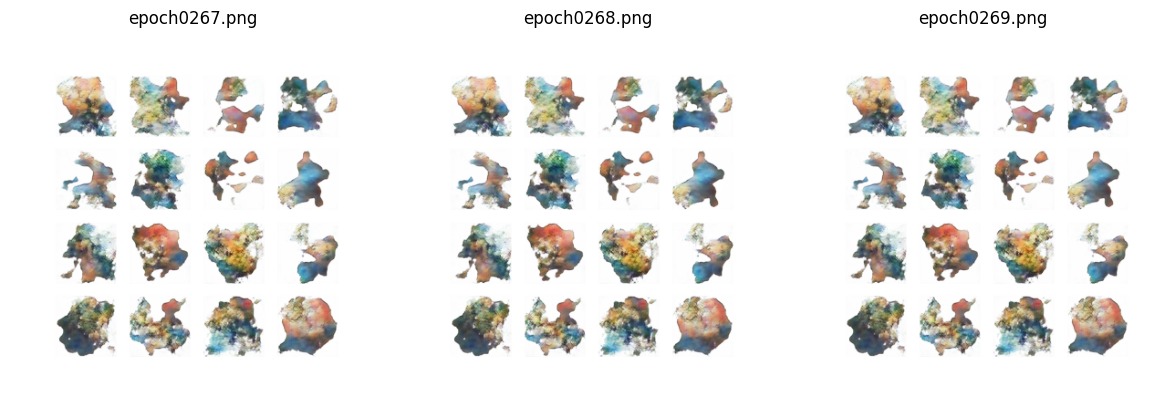

In [ ]:
# 7. 実行
train(train_dataset, EPOCHS)

In [ ]:
# 8. GIF作成
anim_file = 'pokemon_dcgan_github.gif'
filenames = sorted(glob.glob('pokemon_image_at_epoch_*.png'))
gif_size = (128, 128)

frames = []
for filename in filenames:
    pil_img = PILImage.open(filename).resize(gif_size, PILImage.LANCZOS).convert('P', palette=PILImage.ADAPTIVE)
    frames.append(pil_img)

frames[0].save(
    anim_file,
    save_all=True,
    append_images=frames[1:],
    duration=300,    # 各フレーム間 300ms
    loop=0,
    optimize=True    # パレット最適化
)

print(f'GIF saved to {anim_file} ({gif_size[0]}x{gif_size[1]})')

# Notebook内にGIFを表示
with open(anim_file, "rb") as f:
    data = f.read()
    encoded = base64.b64encode(data).decode("utf-8")

ipy_display(HTML(f'<img src="data:image/gif;base64,{encoded}" width="300">'))

In [ ]:
# 9. Checkpointから再開する場合はこちらを実行

# 再開したいエポック数を指定 (例：500)
start_epoch = load_checkpoint(500)

# 残りのエポック分だけ再開実行
train(train_dataset, EPOCHS - start_epoch)